SPAM DETECTION PIPELINE
Data loaded successfully

DATA EXPLORATION

First 5 rows:
  label                                               text Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
--------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   object
 1   text        5572 no

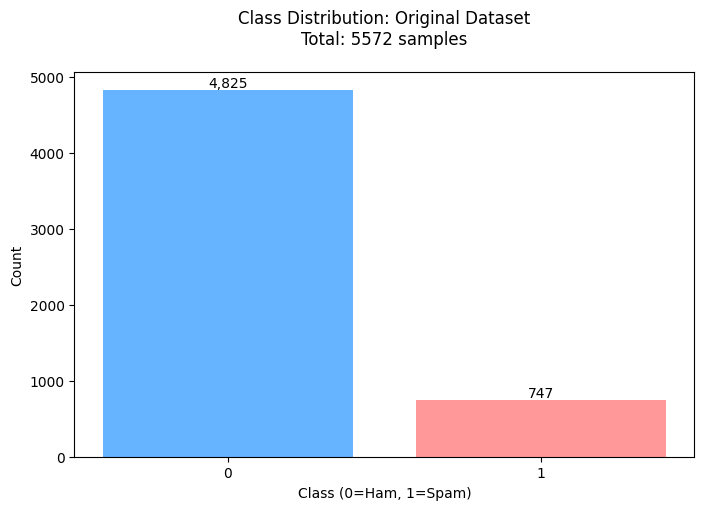


SPAM WORD CLOUD


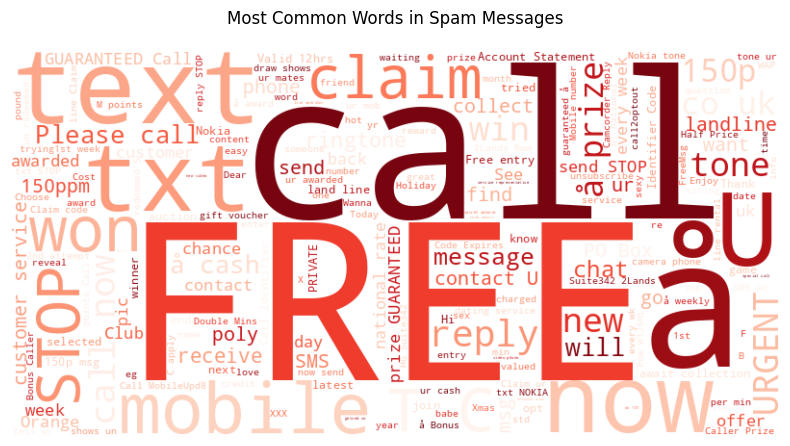


HAM WORD CLOUD


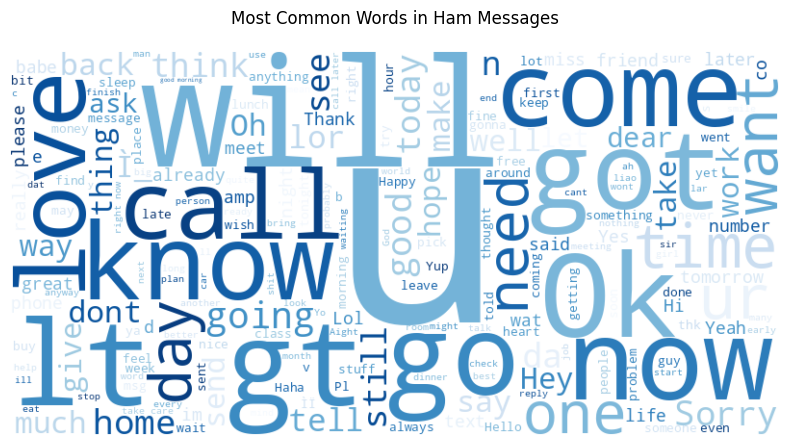


CLASS DISTRIBUTION BEFORE SMOTE


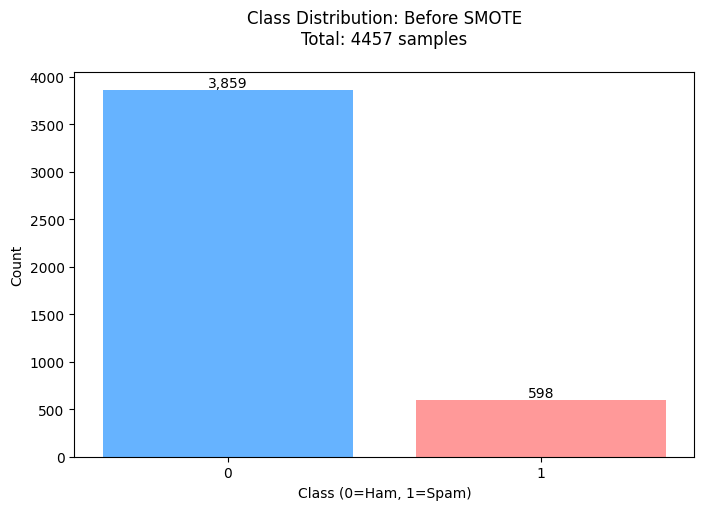


CLASS DISTRIBUTION AFTER SMOTE


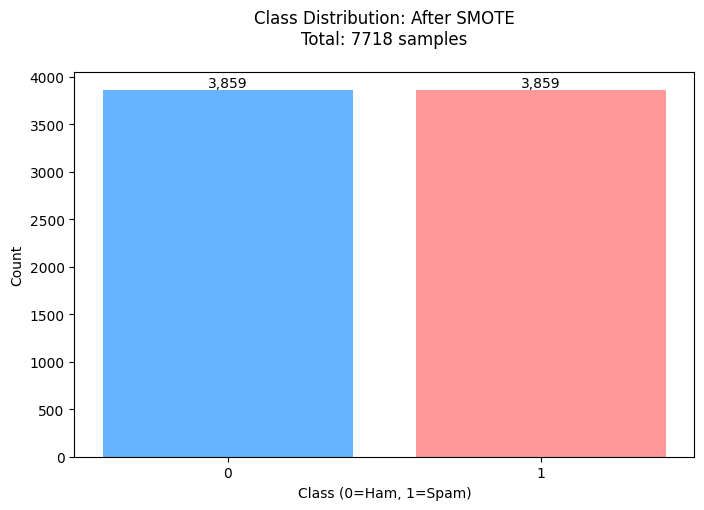


MODEL TRAINING RESULTS


<Figure size 800x600 with 0 Axes>

<Figure size 600x500 with 0 Axes>

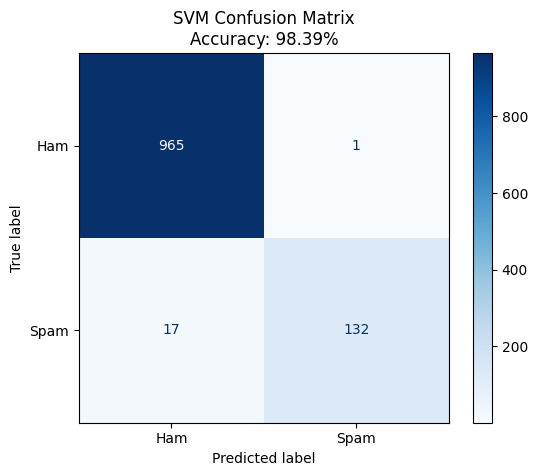


SVM Classification Report
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



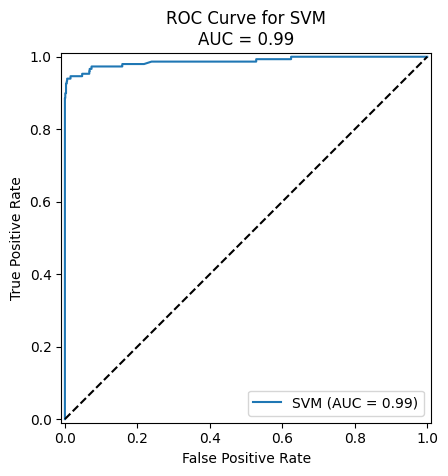

<Figure size 600x500 with 0 Axes>

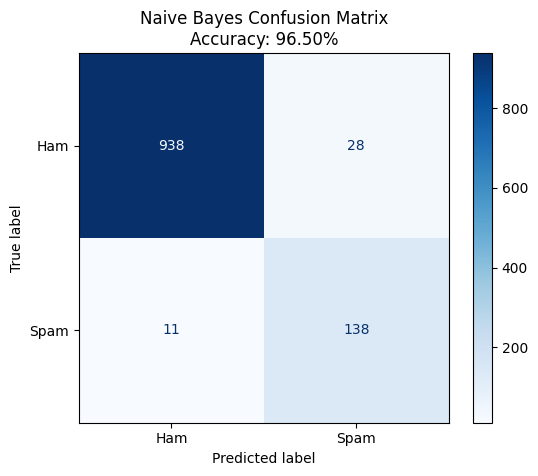


Naive Bayes Classification Report
              precision    recall  f1-score   support

         Ham       0.99      0.97      0.98       966
        Spam       0.83      0.93      0.88       149

    accuracy                           0.97      1115
   macro avg       0.91      0.95      0.93      1115
weighted avg       0.97      0.97      0.97      1115



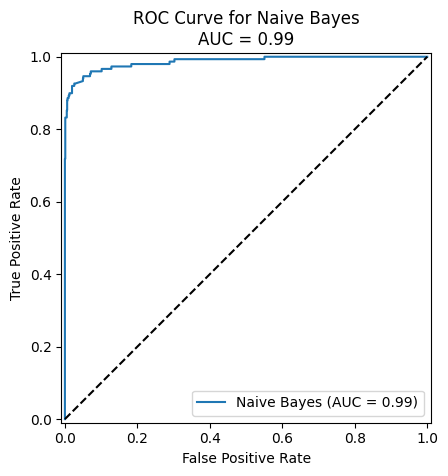

<Figure size 600x500 with 0 Axes>

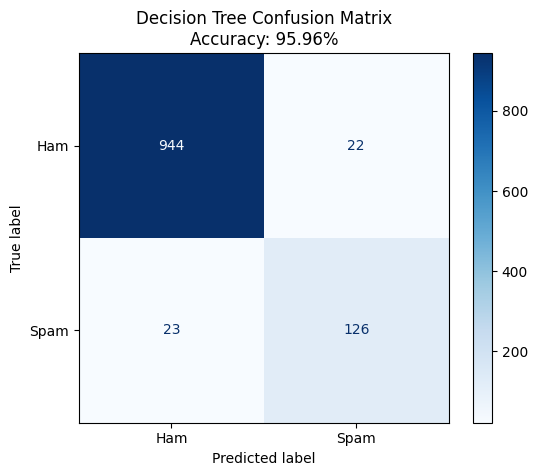


Decision Tree Classification Report
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       966
        Spam       0.85      0.85      0.85       149

    accuracy                           0.96      1115
   macro avg       0.91      0.91      0.91      1115
weighted avg       0.96      0.96      0.96      1115



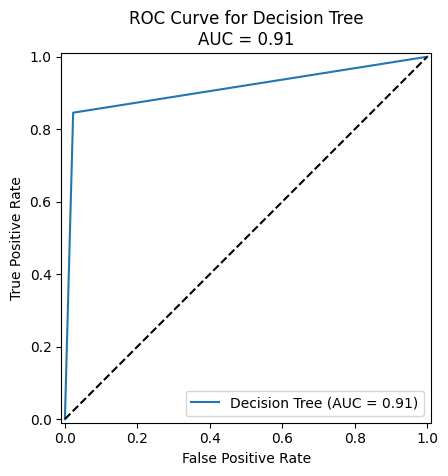


FINAL MODEL COMPARISON
+---------------+------------+------------------+---------------+-----------+
| Model         | Accuracy   | Spam Precision   | Spam Recall   | Spam F1   |
+===============+============+==================+===============+===========+
| SVM           | 98.39%     | 99.25%           | 88.59%        | 93.62%    |
+---------------+------------+------------------+---------------+-----------+
| Naive Bayes   | 96.50%     | 83.13%           | 92.62%        | 87.62%    |
+---------------+------------+------------------+---------------+-----------+
| Decision Tree | 95.96%     | 85.14%           | 84.56%        | 84.85%    |
+---------------+------------+------------------+---------------+-----------+


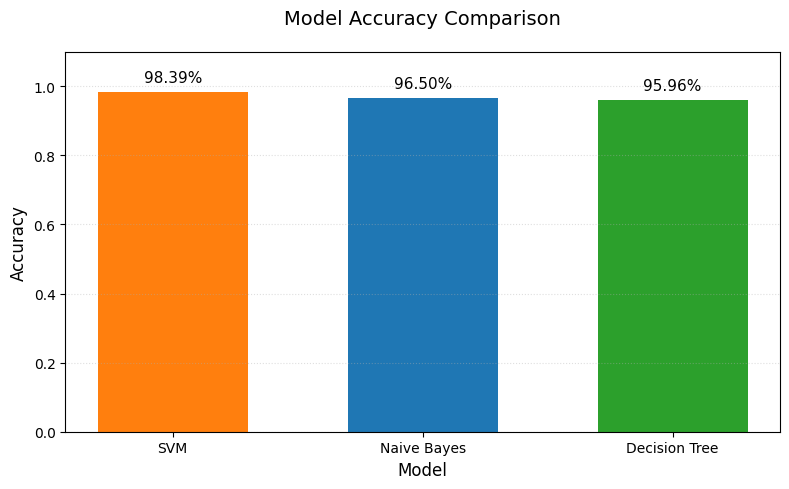


SVM MODEL TESTING RESULTS

Text: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!...
Prediction: SPAM
Probability: 99.54% spam, 0.46% ham
--------------------------------------------------

Text: Hi John, just checking in to see if you're still coming to the meeting tomorrow at 2pm....
Prediction: HAM
Probability: 0.00% spam, 100.00% ham
--------------------------------------------------

Text: URGENT: Your bank account has been compromised. Click this link to secure your account immediately!...
Prediction: SPAM
Probability: 70.46% spam, 29.54% ham
--------------------------------------------------

Text: The project documents are attached. Please review them and let me know your thoughts....
Prediction: HAM
Probability: 0.00% spam, 100.00% ham
--------------------------------------------------

Text: Free iPhone for you! Just pay shipping and handling. Limited time offer!...
Prediction: HAM
Probability: 0.01% spam, 99.99% ham
----------------

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from imblearn.pipeline import make_pipeline, Pipeline
from collections import Counter

import joblib




# ======================
# DATA LOADING FUNCTIONS
# ======================

def load_data(file_path, encoding='latin1'):
    """Load the dataset from a CSV file."""
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        print("Data loaded successfully")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def rename_columns(df, column_mapping):
    """Rename dataframe columns."""
    return df.rename(columns=column_mapping)

def basic_data_exploration(df):
    """Perform basic exploratory data analysis."""
    print("\nDATA EXPLORATION")
    print("="*50)

    print("\nFirst 5 rows:")
    print(df.head())

    print("-"*50)

    print("\nDataset Information:")
    df.info()

    print("-"*50)

    print("\nDescriptive Statistics:")
    print(df.describe(include='all'))

    print("-"*50)

    print("\nMissing Values:")
    print(df.isnull().sum())

# ==============================
# DATA CLEANING & PREPROCESSING
# ==============================

def combine_text_columns(df, text_column, columns_to_combine):
    """Combine multiple text columns into one."""
    for col in columns_to_combine:
        df[col] = df[col].fillna('')

    df[text_column] = df[text_column] + ' ' + df[columns_to_combine].apply(
        lambda row: ' '.join(row.values.astype(str)), axis=1)

    return df.drop(columns=columns_to_combine)

def preprocess_text(text):
    """Clean and preprocess text data."""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def encode_labels(df, label_column):
    """Encode labels to numerical values (spam=1, ham=0)."""
    df[label_column] = df[label_column].apply(lambda x: 1 if str(x).lower() == 'spam' else 0)
    return df

# =====================
# VISUALIZATION
# =====================

def plot_class_distribution(y, title, colors=['#66b3ff', '#ff9999']):
    """Plot class distribution with count values."""
    counts = Counter(y)
    plt.figure(figsize=(8, 5))
    bars = plt.bar(counts.keys(), counts.values(), color=colors)
    plt.title(f'Class Distribution: {title}\nTotal: {len(y)} samples', pad=20)
    plt.xlabel('Class (0=Ham, 1=Spam)')
    plt.ylabel('Count')
    plt.xticks([0, 1])

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom')

    plt.show()

def generate_word_cloud(text, title, color):
    """Generate a single word cloud."""
    wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, pad=20)
    plt.axis('off')
    plt.show()

# =====================
# MODEL TRAINING
# =====================

def prepare_data(df, text_column, label_column):
    """Prepare data and show class distribution before/after SMOTE."""
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_column], df[label_column],
        test_size=0.2,
        random_state=42,
        stratify=df[label_column]
    )

    # Show original distribution
    print("\nCLASS DISTRIBUTION BEFORE SMOTE")
    print("="*50)
    plot_class_distribution(y_train, "Before SMOTE")

    # Apply SMOTE and show new distribution
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_vec = vectorizer.fit_transform(X_train)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_vec, y_train)

    print("\nCLASS DISTRIBUTION AFTER SMOTE")
    print("="*50)
    plot_class_distribution(y_train_smote, "After SMOTE")

    return X_train, X_test, y_train, y_test

def initialize_models():
    """Initialize classification models."""
    return {
        "SVM": SVC(kernel='rbf', C=10, gamma=0.1, probability=True),
        "Naive Bayes": MultinomialNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42)
    }

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate models with clear output."""
    models = initialize_models()
    results = []

    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        pipeline = make_pipeline(
            TfidfVectorizer(max_features=5000, stop_words='english'),
            SMOTE(random_state=42),
            model
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for positive class

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'], output_dict=True)

        # Store results
        results.append({
            'Model': name,
            'Accuracy': f"{accuracy:.2%}",
            'Spam Precision': f"{report['Spam']['precision']:.2%}",
            'Spam Recall': f"{report['Spam']['recall']:.2%}",
            'Spam F1': f"{report['Spam']['f1-score']:.2%}"
        })

        # Display confusion matrix
        plt.figure(figsize=(6, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                              display_labels=['Ham', 'Spam'],
                                              cmap='Blues')
        plt.title(f'{name} Confusion Matrix\nAccuracy: {accuracy:.2%}')
        plt.show()

        # Print classification report
        print(f"\n{name} Classification Report")
        print("="*50)
        print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot()
        plt.title(f'ROC Curve for {name}\nAUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.show()

    return pd.DataFrame(results)
# =====================
# MODEL COMPARISON VISUALIZATION
# =====================

def plot_model_comparison(results_df):
    """Visualize model comparison with accuracy scores."""
    # Convert accuracy strings to floats
    results_df['Accuracy'] = results_df['Accuracy'].str.rstrip('%').astype('float') / 100

    # Define colors for each model
    colors = ['#ff7f0e', '#1f77b4', '#2ca02c']

    # Create a compact plot
    plt.figure(figsize=(8, 5))

    # Plot the bars
    bars = plt.bar(results_df["Model"], results_df["Accuracy"],
                   color=colors,
                   width=0.6)

    # Formatting
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Model Accuracy Comparison", fontsize=14, pad=20)
    plt.ylim(0, 1.1)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.,
                 height + 0.02,
                 f"{height:.2%}",
                 ha='center',
                 va='bottom',
                 fontsize=11)

    plt.grid(axis='y', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

# =====================
# MODEL TESTING FUNCTION
# =====================

def test_svm_model(X_train, y_train, new_texts):
    """
    Test the SVM model with new text samples.

    Args:
        X_train: Training text data (for fitting the vectorizer)
        y_train: Training labels (for SMOTE)
        new_texts: List of new text samples to classify
    """
    # Create the pipeline
    svm_pipeline = make_pipeline(
        TfidfVectorizer(max_features=5000, stop_words='english'),
        SMOTE(random_state=42),
        SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
    )

    # Fit the pipeline
    svm_pipeline.fit(X_train, y_train)

    # Preprocess new texts
    processed_texts = [preprocess_text(text) for text in new_texts]

    # Make predictions
    predictions = svm_pipeline.predict(processed_texts)
    probabilities = svm_pipeline.predict_proba(processed_texts)

    # Display results
    print("\nSVM MODEL TESTING RESULTS")
    print("="*50)
    for text, pred, prob in zip(new_texts, predictions, probabilities):
        print(f"\nText: {text[:100]}...")  # Show first 100 chars
        print(f"Prediction: {'SPAM' if pred == 1 else 'HAM'}")
        print(f"Probability: {prob[1]*100:.2f}% spam, {prob[0]*100:.2f}% ham")
        print("-"*50)

# =====================
# UPDATED MAIN FUNCTION
# =====================

def main():
    print("SPAM DETECTION PIPELINE")
    print("="*50)

    # 1. Load data
    df = load_data('spam.csv')
    if df is None:
        return

    # 2. Rename columns
    df = rename_columns(df, {'v1': 'label', 'v2': 'text'})

    # 3. Initial exploration
    basic_data_exploration(df)

    # 4. Combine text columns
    df = combine_text_columns(df, 'text', ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

    # Show data after combining columns
    print("\nDATA AFTER COMBINING COLUMNS")
    print("="*50)
    print("\nFirst 5 rows after combining columns:")
    print(df.head())

    print("-"*50)

    print("\nMissing values after combining columns:")
    print(df.isnull().sum())

    # 5. Visualize label distribution
    print("\nLABEL DISTRIBUTION")
    print("="*50)
    plot_class_distribution(df['label'].map({'ham': 0, 'spam': 1}), "Original Dataset")

    # 6. Word clouds
    spam_text = ' '.join(df[df['label'] == 'spam']['text'])
    ham_text = ' '.join(df[df['label'] == 'ham']['text'])

    print("\nSPAM WORD CLOUD")
    print("="*50)
    generate_word_cloud(spam_text, "Most Common Words in Spam Messages", 'Reds')

    print("\nHAM WORD CLOUD")
    print("="*50)
    generate_word_cloud(ham_text, "Most Common Words in Ham Messages", 'Blues')

    # 7. Preprocessing
    df['text'] = df['text'].apply(preprocess_text)
    df = encode_labels(df, 'label')

    # 8. Prepare data and show SMOTE effect
    X_train, X_test, y_train, y_test = prepare_data(df, 'text', 'label')

    # 9. Train and evaluate models
    print("\nMODEL TRAINING RESULTS")
    print("="*50)
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # 10. Final results
    print("\nFINAL MODEL COMPARISON")
    print("="*50)
    print(results.to_markdown(tablefmt='grid', index=False))

    # 11. Plot model comparison
    plot_model_comparison(results)

    # 12. Test the SVM model with new examples
    test_examples = [
        "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!",
        "Hi John, just checking in to see if you're still coming to the meeting tomorrow at 2pm.",
        "URGENT: Your bank account has been compromised. Click this link to secure your account immediately!",
        "The project documents are attached. Please review them and let me know your thoughts.",
        "Free iPhone for you! Just pay shipping and handling. Limited time offer!"
    ]

    test_svm_model(X_train, y_train, test_examples)

if __name__ == "__main__":
    main()